# Global Research Keyword Analysis 

In [1]:
# Setup and Data Loading
import pandas as pd
import numpy as np
import folium
from folium import plugins
import ast
from collections import Counter
from IPython.display import IFrame, display
import re
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import requests
import branca
from branca.element import Template, MacroElement
import numpy as np
import io
from PIL import Image
from collections import defaultdict

# Load dataset and drop nulls in critical columns
df = pd.read_csv('../2025_Data_Hetansh.csv')
# df = df.dropna(subset=['affiliations', 'keywords', 'smart_keywords'])

coords_df = pd.read_csv('../world_coords.csv')

# GeoJSON URL for country boundaries
political_countries_url = "http://geojson.xyz/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"

plt.style.use('dark_background')
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams.update({'figure.dpi': 150})

def display_html(location: str):
    from IPython.display import HTML
    from IPython.display import IFrame
    import base64
    with open(location, "r") as f:
        html_content = f.read()
    
    html_str = "data:text/html;base64," + base64.b64encode(html_content.encode('utf-8')).decode('utf-8')
    display(IFrame(src=html_str, width='100%', height='500px'))

def saving_plot(map, filename):
    img_data = map._to_png(5)
    img = Image.open(io.BytesIO(img_data))
    img.save(filename)


In [2]:
# Using affiliations column to get countries

# 1. Setup the replacement dictionary
replacement_dict = {
    'USA': 'United States',
    'UK': 'United Kingdom',
    'UAE': 'United Arab Emirates',
    'United States of America': 'United States',
    "People's Republic of China": 'China',
    'The Netherlands': 'Netherlands',
    'Republic of Korea': 'South Korea',
    'The United Kingdom': 'United Kingdom'
}

# 2. Load the reference countries
# Assuming 'world_coords.csv' is in the current directory
try:
    world_coords = pd.read_csv('../world_coords.csv')
    # Create a set of valid countries for O(1) lookup speed
    valid_countries = set(world_coords['country'].unique())
except FileNotFoundError:
    print("Error: 'world_coords.csv' not found. Please ensure the file exists.")
    valid_countries = set()

# 3. Define the extraction function
def extract_countries_from_affiliations(affil_text):
    """
    Parses an affiliation string, splits by semicolon, and extracts 
    countries based on the valid_countries list and replacement_dict.
    """
    if not isinstance(affil_text, str) or not affil_text:
        return []

    found_countries = []
    
    # Split the row containing multiple affiliations by ';'
    affiliations = affil_text.split(';')
    
    for affil in affiliations:
        affil = affil.strip()
        if not affil:
            continue
            
        # Strategy: Look at the text after the last comma first (standard address format),
        # then fall back to checking the end of the string.
        
        # Get the last part after the last comma
        if ',' in affil:
            last_part = affil.split(',')[-1].strip()
        else:
            last_part = affil

        # Remove trailing periods (e.g., "USA." -> "USA")
        last_part_clean = last_part.rstrip('.')
        
        country_candidate = None

        # Check 1: Is this exact text in our replacement dict?
        if last_part_clean in replacement_dict:
            country_candidate = replacement_dict[last_part_clean]
        
        # Check 2: Is this exact text a valid country?
        elif last_part_clean in valid_countries:
            country_candidate = last_part_clean
            
        # Check 3 (Fallback): If the address is complex, iterate through keys/countries
        # to see if the string ENDS with them.
        else:
            # Check replacements via regex at end of string
            for key, val in replacement_dict.items():
                # Matches "Key" at end of string, optionally followed by a dot
                if re.search(r'\b' + re.escape(key) + r'\.?$', affil):
                    country_candidate = val
                    break
            
            # If still not found, check valid countries via regex at end of string
            if not country_candidate:
                for country in valid_countries:
                    if re.search(r'\b' + re.escape(country) + r'\.?$', affil):
                        country_candidate = country
                        break

        # If we identified a valid country (and it exists in our reference list)
        if country_candidate:
            # Ensure the replaced name is actually in our valid list 
            # (e.g. if 'United States' is in world_coords)
            if country_candidate in valid_countries:
                found_countries.append(country_candidate)
            else:
                # If the replacement map gives "United States" but world_coords 
                # strictly uses "USA" (unlikely based on your dict, but good safety),
                # we keep the candidate.
                found_countries.append(country_candidate)
                
    return found_countries

# 4. Apply the function to the dataframe
# Assuming your dataframe is named 'data'
if 'df' in locals():
    df['affil_countries'] = df['affiliations'].apply(extract_countries_from_affiliations)

    # Display the result to verify
    print(df[['affiliations', 'affil_countries']].head())
else:
    print("Dataframe 'data' not found. Please load your data first.")


# For how many columns do we have counties in both affil_countries and latex_countries
count_both = 0
for affil_list, latex_list in zip(df['affil_countries'], df['latex_countries']):
    if affil_list and latex_list:
        count_both += 1
count_both

# Country name mismatches between affil_countries and latex_countries

def check_country_mismatches(df):
    """
    Identifies rows where the extracted 'affil_countries' list does not match 
    the parsed 'latex_countries' string.
    """
    
    # List to store indices of mismatching rows
    mismatch_indices = []

    # Iterate through the dataframe
    for index, row in df.iterrows():
        
        # 1. Get the generated list from the previous step
        derived_list = row['affil_countries']
        
        # 2. Get the manual/latex string
        latex_str = row['latex_countries']
        
        # 3. Filter: Only check rows that have valid entries in BOTH columns
        # Check if derived_list is valid (not None and not empty)
        has_derived = isinstance(derived_list, list) and len(derived_list) > 0
        
        # Check if latex_str is valid (not NaN/None and not empty string)
        has_latex = pd.notna(latex_str) and str(latex_str).strip() != ''
        
        if has_derived and has_latex:
            # 4. Convert latex string to list for comparison
            # Split by comma, strip whitespace around the country name
            latex_list = [c.strip() for c in str(latex_str).split(',') if c.strip()]
            
            # 5. Strict comparison (Order and Count must match exactly)
            if derived_list != latex_list:
                mismatch_indices.append(index)

    # 6. Create a dataframe subset containing only mismatches
    mismatched_rows = df.loc[mismatch_indices].copy()
    
    # Add a column showing the parsed latex list for easier visual comparison
    mismatched_rows['latex_list_parsed'] = mismatched_rows['latex_countries'].apply(
        lambda x: [c.strip() for c in str(x).split(',') if c.strip()]
    )
    
    return mismatched_rows

# --- Execution ---

# Run the check
mismatches = check_country_mismatches(df)

# Output results
if mismatches.empty:
    print("Success! No mismatches found between affiliations and latex_countries.")
else:
    print(f"Found {len(mismatches)} mismatches.")
    print("\nSample of mismatches (showing derived vs latex):")
    
    # specific columns to view
    cols_to_view = ['affil_countries', 'latex_list_parsed', 'affiliations']
    
    # Adjust pandas display options to ensure we see the full columns
    with pd.option_context('display.max_colwidth', None):
        print(mismatches[cols_to_view].head(10))

    # Optional: Save to CSV to inspect manually
    # mismatches.to_csv('country_mismatches.csv')


# All countires column and first authors column

def process_country_columns(row):
    """
    Helper function to generate the 'all_countries' and 'first_author' data
    based on row values.
    """
    # --- Logic for 'all_countries' ---
    # Default to the extracted countries from affiliations
    final_all_countries = row['affil_countries']
    
    # Check if the list is empty or invalid (NaN/None)
    is_affil_empty = not isinstance(final_all_countries, list) or len(final_all_countries) == 0
    
    # If empty, fill from 'latex_countries'
    if is_affil_empty:
        latex_val = row.get('latex_countries')
        if pd.notna(latex_val) and str(latex_val).strip() != '':
            # Convert comma-separated string to list
            final_all_countries = [x.strip() for x in str(latex_val).split(',') if x.strip()]
        else:
            final_all_countries = []

    # --- Logic for 'first_author' ---
    first_author_countries = []
    affil_text = row.get('affiliations')
    
    # 1. Try to get first author from 'affiliations' column
    # We split by ';' and take the first segment (index 0)
    if pd.notna(affil_text) and str(affil_text).strip() != '':
        first_segment = str(affil_text).split(';')[0]
        # Use the function defined in Step 1 to extract country from just this segment
        first_author_countries = extract_countries_from_affiliations(first_segment)
    
    # 2. If no country found in affiliations, fallback to first entry of 'latex_countries'
    if not first_author_countries:
        latex_val = row.get('latex_countries')
        if pd.notna(latex_val) and str(latex_val).strip() != '':
            # Split by comma and take the first item
            first_latex_country = str(latex_val).split(',')[0].strip()
            if first_latex_country:
                first_author_countries = [first_latex_country]

    return pd.Series([final_all_countries, first_author_countries])

# Apply the logic to the dataframe
if 'df' in locals():
    df[['all_countries', 'first_author']] = df.apply(process_country_columns, axis=1)

    # Display results to verify
    cols_to_show = ['affiliations', 'latex_countries', 'all_countries', 'first_author']
    print(df[cols_to_show].head())
else:
    print("Dataframe 'data' not found.")

                                        affiliations  \
0  ['Space Telescope Science Institute, 3700 San ...   
1                                                 []   
2  ['INAF/IAPS, 00133, Rome, Italy', 'INAF/IAPS, ...   
3                                                 []   
4  ["Shanghai Astronomical Observatory, Chinese A...   

                       affil_countries  
0       [United States, United States]  
1                                   []  
2  [Italy, Italy, Italy, Italy, Italy]  
3                                   []  
4                [China, China, China]  
Found 6672 mismatches.

Sample of mismatches (showing derived vs latex):
                                            affil_countries  \
4                                     [China, China, China]   
5                                     [China, China, China]   
7                                     [Spain, Spain, Spain]   
8             [United States, United States, United States]   
11                           

In [3]:
# Robust Country Extraction and Keyword Cleaning
def extract_country_from_affil(affil_str):
    if not isinstance(affil_str, str) or not affil_str:
        return None
    
    country_map = {
        'usa': 'United States',
        'united states': 'United States',
        'uk': 'United Kingdom',
        'united kingdom': 'United Kingdom',
        'china': 'China',
        "people's republic of china": 'China',
        'germany': 'Germany',
        'france': 'France',
        'italy': 'Italy',
        'india': 'India',
        'japan': 'Japan',
        'canada': 'Canada',
        'australia': 'Australia',
        'spain': 'Spain',
        'russia': 'Russia',
        'brazil': 'Brazil',
        'south korea': 'South Korea',
        'switzerland': 'Switzerland',
        'netherlands': 'Netherlands',
        'sweden': 'Sweden',
        'taiwan': 'Taiwan',
        'israel': 'Israel',
        'austria': 'Austria',
        'denmark': 'Denmark',
        'belgium': 'Belgium',
        'finland': 'Finland',
        'norway': 'Norway',
        'poland': 'Poland',
        'mexico': 'Mexico',
        'chile': 'Chile',
        'argentina': 'Argentina',
        'czech republic': 'Czech Republic',
        'turkey': 'Turkey',
        'greece': 'Greece',
        'portugal': 'Portugal',
        'singapore': 'Singapore',
        'south africa': 'South Africa',
        'hong kong': 'Hong Kong',
        'new zealand': 'New Zealand',
        'ireland': 'Ireland',
        'hungary': 'Hungary',
        'colombia': 'Colombia'
    }
    
    parts = [p.strip().lower() for p in affil_str.split(',')]
    for part in reversed(parts):
        clean_part = re.sub(r'[^a-zA-Z\s]', '', part).strip()
        if clean_part in country_map:
            return country_map[clean_part]
    
    affil_lower = affil_str.lower()
    for key, val in country_map.items():
        if key in affil_lower:
            return val
            
    return None

def process_affiliations(row):
    try:
        aff_raw = row['affiliations']
        affs = aff_raw.split(';') if ';' in aff_raw else [aff_raw]
        extracted_countries = []
        for aff in affs:
            country = extract_country_from_affil(aff)
            if country:
                extracted_countries.append(country)
        return list(set(extracted_countries))
    except:
        return []

def clean_keyword(k):
    # Remove things like "(573)" from "Galaxies (573)"
    s = re.sub(r'\s*\(\d+\)\s*$', '', str(k)).strip()
    # Filter out email addresses
    if '@' in s:
        return None
    return s

df['countries_extracted'] = df.apply(process_affiliations, axis=1)


In [4]:
# Aggregation and Coloring Functions
def get_country_top_keywords(df, col_name):
    country_keywords = {}
    for _, row in df.iterrows():
        try:
            countries = row['all_countries']
            # Parse keywords
            raw_keywords = ast.literal_eval(row[col_name])
            cleaned_keywords = [clean_keyword(k) for k in raw_keywords if k]
            cleaned_keywords = [k for k in cleaned_keywords if k] # Filter None
            
            if not countries or not cleaned_keywords: continue
            
            for country in countries:
                if country not in country_keywords:
                    country_keywords[country] = Counter()
                country_keywords[country].update(cleaned_keywords)
        except:
            continue
            
    results = {}
    all_top_keywords = set()
    for country, counts in country_keywords.items():
        most_common = counts.most_common(5)
        if most_common:
            results[country] = most_common
            all_top_keywords.add(most_common[0][0])
            
    return results, sorted(list(all_top_keywords))

def create_legend_html(keyword_colors, title):
    legend_html = f'''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 250px; height: auto; 
                border:2px solid grey; z-index:9999; font-size:12px;
                background-color:white; opacity: 0.9; padding: 10px; max-height: 400px; overflow-y: auto;">
    <b>{title}</b><br>
    '''
    for kw, color in keyword_colors.items():
        legend_html += f'<i style="background:{color}; width:12px; height:12px; float:left; margin-right:5px; border: 1px solid black;"></i>{kw}<br>'
    legend_html += '</div>'
    return legend_html

def generate_keyword_map(data_dict, unique_keywords, title, filename):
    m = folium.Map(location=[20, 0], zoom_start=2.3, tiles='cartodb positron')
    
    # Create colormap using 'jet'
    jet = cm.get_cmap('jet', len(unique_keywords))
    keyword_colors = {kw: colors.to_hex(jet(i)) for i, kw in enumerate(unique_keywords)}
    
    # GeoJSON with colors
    def style_function(feature):
        country_name = feature['properties']['name']
        mapping = {
            'United States': 'United States', 'United States of America': 'United States',
            'United Kingdom': 'United Kingdom', 'China': 'China',
            'Czech Rep.': 'Czech Republic', 'Dem. Rep. Korea': 'South Korea',
            'Korea': 'South Korea'
        }
        std_name = mapping.get(country_name, country_name)
        
        kw_info = data_dict.get(std_name)
        if kw_info:
            top_kw = kw_info[0][0]
            return {
                'fillColor': keyword_colors.get(top_kw, '#ffffff'),
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.6
            }
        return {
            'fillColor': '#ffffff',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.1
        }

    folium.GeoJson(
        political_countries_url,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'])
    ).add_to(m)
    
    # Add Markers (Circles Only, No Text Labels)
    for country, top_kws in data_dict.items():
        if country in coords_df['country'].values:
            lat = coords_df[coords_df['country'] == country]['latitude'].values[0]
            lon = coords_df[coords_df['country'] == country]['longitude'].values[0]
            
            top_kw = top_kws[0][0]
            
            # folium.CircleMarker(
            #     location=[lat, lon],
            #     radius=4,
            #     color='black',
            #     weight=1,
            #     fill=True,
            #     fill_color=keyword_colors.get(top_kw, 'white'),
            #     fill_opacity=1,
            #     popup=f"<b>{country}</b><br>Top Keyword: {top_kw}<br>Total Keywords:<br>" + "<br>".join([f"{k}: {c}" for k, c in top_kws])
            # ).add_to(m)

    # Add Legend
    m.get_root().html.add_child(folium.Element(create_legend_html(keyword_colors, title)))
    
    m.save(filename)
    return m


## Map 1: Top Keywords per Country (All Authors)

In [5]:
# Generate Map 1: Most Frequent Keywords
print("Processing keywords column...")
kw_results, unique_kws = get_country_top_keywords(df, 'keywords')
k_map =generate_keyword_map(kw_results, unique_kws, "Top Research Keywords", "global_keywords_map.html")
saving_plot(k_map, "./plots/keyword_map.png")

Processing keywords column...


C:\Users\hetan\AppData\Local\Temp\ipykernel_17060\1828912061.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap('jet', len(unique_keywords))


## Map 2: Top Smart Keywords per Country (All Authors)

In [6]:
# Generate Map 2: Most Frequent Smart Keywords
print("Processing smart_keywords column...")
skw_results, unique_skws = get_country_top_keywords(df, 'smart_keywords_2')
k2_map =generate_keyword_map(skw_results, unique_skws, "Top Smart Keywords", "global_smart_keywords_map.html")
k2_map =saving_plot(k2_map, "./plots/smart_keyword_map.png")

Processing smart_keywords column...


C:\Users\hetan\AppData\Local\Temp\ipykernel_17060\1828912061.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap('jet', len(unique_keywords))


# Telescopes

Use `masked_data` dataframe to see the telescope map

In [7]:
#telescope_citation_analysis.csv
from PIL import Image
jwst_img = Image.open('../Images/james-webb-space-telescope-graphic-illustration-astronomy-vector.jpg')
gaia_img = Image.open('../Images/images.jpeg')
alma_img = Image.open('../Images/alma-features.png')
tess_img = Image.open('../Images/tess-telescope.png')
integral_img = Image.open('../Images/INTEGRAL_spacecraft_model.png')
fermi_img = Image.open('../Images/Fermi_Gamma-ray_Space_Telescope_spacecraft_model.png')
sdss_img = Image.open('../Images/SDSS_telescope.png')
lisa_img = Image.open('../Images/Lisa_logo-mission-patch-1024x1024.jpg')
lsst_img = Image.open('../Images/Large_Synoptic_Survey_Telescope_3_4_render_2013.png')
newton_img = Image.open('../Images/XMM-Newton_spacecraft_model.png')

image_list = {
    'JWST': jwst_img,
    'GAIA': gaia_img,
    'ALMA': alma_img,
    'TESS': tess_img,
    'INTEGRAL': integral_img,
    'Fermi': fermi_img,
    'SDSS': sdss_img,
    'LISA': lisa_img,
    'LSST': lsst_img,
    'XMM-Newton': newton_img,
}

In [8]:
print(df['published_journal'].notna().sum())

1165


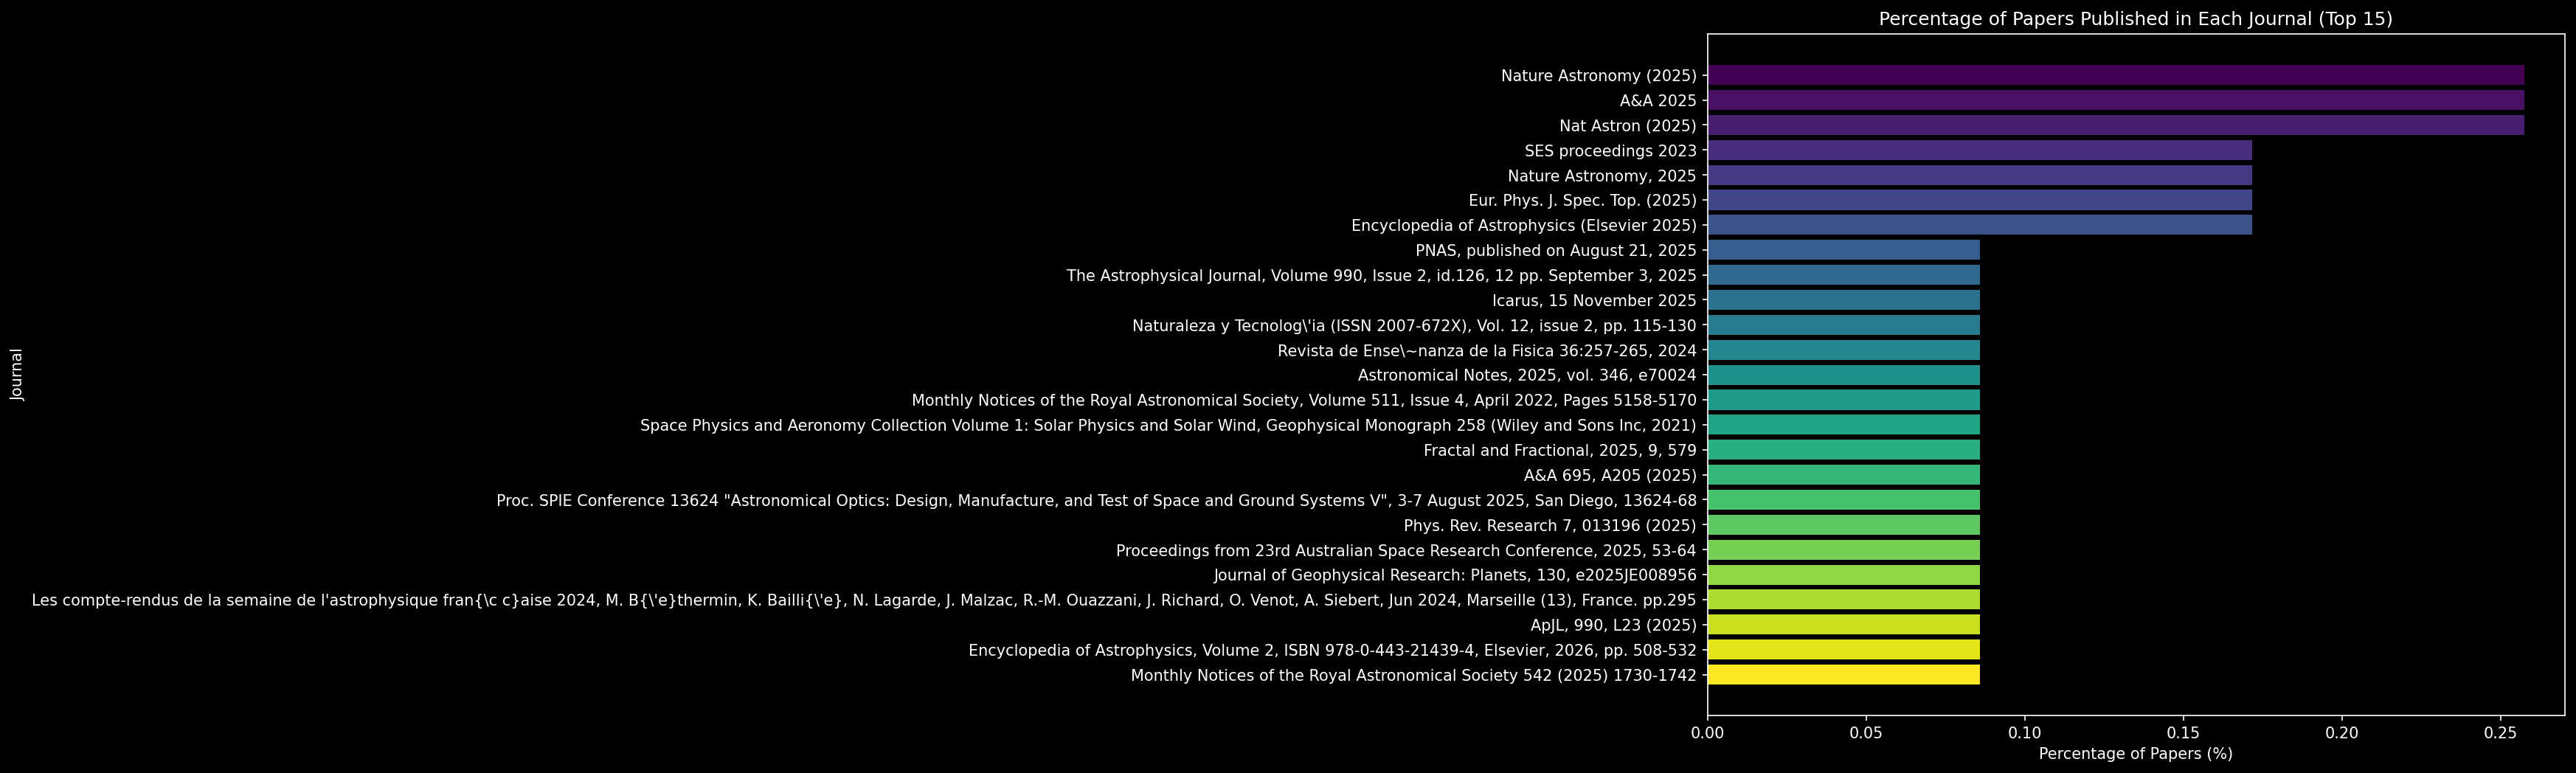

In [9]:
journal_counts = df['published_journal'].value_counts(normalize=True).head(25) * 100
plt.figure(figsize=(10, 8))
plt.barh(journal_counts.index, journal_counts.values, color=plt.cm.viridis(np.linspace(0, 1, len(journal_counts))))
plt.xlabel('Percentage of Papers (%)')
plt.ylabel('Journal')
plt.title('Percentage of Papers Published in Each Journal (Top 15)')
plt.gca().invert_yaxis()
plt.show()

In [10]:
list_of_telescopes = [
    'HST',
    'CSST',
    'Chandra',
    'Spitzer',
    'JWST',
    'VLT',
    'ALMA',
    'Keck',
    'Subaru',
    'Euclid',
    'Vera C. Rubin Observatory',
    'SDSS',
    'GAIA',
    'ZWICKY',
    'LIGO',
    'LISA',
    'Fermi',
    'Swift',
    'TESS',
    'NICER',
    'NuSTAR',
    'XMM-Newton',
    'INTEGRAL',
    'SPHEREx',
    'SVOM',
    'AstroSat',
    'HXMT',
    'XRISM',
    'Einstein Probe',
    'IXPE',
    'XPoSat',
    'IRIS',
    'CUTE',
    'GLIDE',
    'NEOSSat',
    'CHEOPS',
    'DAMPE',
    'CALCET',
    'LSST',
]

long_names = {
    'HST': 'Hubble Space Telescope',
    'CSST': 'China Space Station Telescope',
    'JWST': 'James Webb Space Telescope',
    'VLT': 'Very Large Telescope',
    'ALMA': 'Atacama Large Millimeter/submillimeter Array',
    'SDSS': 'Sloan Digital Sky Survey',
    'LIGO': 'Laser Interferometer Gravitational-Wave Observatory',
    'LISA': 'Laser Interferometer Space Antenna',
    'ZWICKY': 'Zwicky Transient Facility',
    'Chandra': 'Chandra X-ray Observatory',
    'Spitzer': 'Spitzer Space Telescope',
    'Fermi': 'Fermi Gamma-ray Space Telescope',
    'Swift': 'Neil Gehrels Swift Observatory',
    'TESS': 'Transiting Exoplanet Survey Satellite',
    'NICER': 'Neutron star Interior Composition Explorer',
    'GAIA': 'Global Astrometric Interferometer for Astrophysics',
    'NuSTAR': 'Nuclear Spectroscopic Telescope Array',
    'XMM-Newton': 'X-ray Multi-Mirror Mission - Newton',
    'INTEGRAL': 'INTErnational Gamma-Ray Astrophysics Laboratory',
    'SPHEREx': 'Spectro-Photometer for the History of the Universe, Epoch of Reionization, and Ices Explorer',
    'SVOM': 'Space-based multi-band astronomical Variable Objects Monitor',
    'AstroSat': 'AstroSat Space Observatory',
    'HXMT': 'Hard X-ray Modulation Telescope',
    'XRISM': 'X-ray Imaging and Spectroscopy Mission',
    'Einstein Probe': 'Einstein Probe X-ray Observatory',
    'IXPE': 'Imaging X-ray Polarimetry Explorer',
    'XPoSat': 'X-ray Polarimeter Satellite',
    'IRIS': 'Interface Region Imaging Spectrograph',
    'CUTE': 'Colorado Ultraviolet Transit Experiment',
    'GLIDE': 'Carruthers Geocorona Observatory',
    'NEOSSat': 'Near-Earth Object Surveillance Satellite',
    'CHEOPS': 'Characterising Exoplanet Satellite',
    'DAMPE': 'DArk Matter Particle Explorer',
    'CALCET': 'CALorimetric Electron Telescope',
    'RST': 'Roman Space Telescope',
    'RST': 'Nancy Grace Roman Space Telescope',
    'Vera Rubin': 'Vera C. Rubin Observatory',
    'Rubin': 'Vera C. Rubin Observatory',
    'Vera Rubin': 'LSST',
    'Vera Rubin': 'Legacy Survey of Space and Time',
}


df['telescope'] = np.nan                       # make sure column exists
for idx in df.index:                             # use real index labels
    for col in ('title', 'abstract'):
        txt = df.at[idx, col]
        if isinstance(txt, str):
            for tel in list_of_telescopes:
                if tel.lower() in txt.lower():
                    df.at[idx, 'telescope'] = tel
                    break                        # first match wins

C:\Users\hetan\AppData\Local\Temp\ipykernel_17060\439180736.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'INTEGRAL' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'telescope'] = tel


In [11]:
mask = df['telescope'].notna()
masked_data = df[mask]
masked_data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,latex_countries,affil_countries,all_countries,first_author,countries_extracted,telescope
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,1,1,[],[],NaN,"[Italy, Italy, Italy, Italy, Italy]","[Italy, Italy, Italy, Italy, Italy]",[Italy],[Italy],INTEGRAL
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,0,0,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France",[],"[Italy, France]",[Italy],[],Fermi
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany,"[China, China, China]","[China, China, China]",[China],[China],ALMA
9,IXPE observations of supernova remnants,Supernova remnants (SNRs) are among the most i...,['Riccardo Ferrazzoli'],9.0,14.0,1.0,arxiv.org/pdf/2501.12719,High Energy Astrophysical Phenomena,NaN,appear in the Proceedings of the 17th Marcel G...,...,1,1,"['Cosmic ray objects', 'Cosmic ray sources', '...",[],"United Kingdom, United States, United States, ...",[],"[United Kingdom, United States, United States,...",[United Kingdom],[],IXPE
14,A Pilot Study for the CSST Slitless Spectrosco...,The wide survey of the Chinese Space Station T...,"['Yuxuan Pang', 'Xue-Bing Wu', 'Yuming Fu', 'R...",15.0,19.0,5.0,arxiv.org/pdf/2501.12665,Astrophysics of Galaxies,NaN,NaN,...,1,1,"['A stars', 'AB magnitude', 'AGN']",['Active galactic nuclei (16) — Galactic and e...,"China, China, China, China, China, China, Chin...","[China, China, Netherlands, China, China, Chin...","[China, China, Netherlands, China, China, Chin...",[China],[China],CSST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18648,LUNCH: A Lightweight Unified Deep-Learning Fra...,The increasing data volume of high-energy spac...,"['Peng Zhang', 'Chen-Wei Wang', 'Zheng-Hang Yu...",5.0,16.0,5.0,arxiv.org/pdf/2512.24764,Instrumentation and Methods for Astrophysics,['High Energy Astrophysical Phenomena'],NaN,...,0,0,"['Astronomy data visualization', 'Classificati...","['Gamma-ray bursts (629)', 'Convolutional neur...","China, China, China, China, China, China, Chin...",[],"[China, China, China, China, China, China, Chi...",[China],[],Fermi
18649,TTC: Transformer-based TDE Classifier for the ...,We propose the Transformer-based Tidal disrupt...,"['Ranfang Zheng', 'Zheyu Lin', 'Xu Kong', 'Dez...",9.0,17.0,7.0,arxiv.org/pdf/2512.24782,Instrumentation and Methods for Astrophysics,['High Energy Astrophysical Phenomena'],NaN,...,1,1,"['Catalogs', 'Classification', 'Classification...",['Tidal disruption events — Transformer — Tran...,"China, China, China, China, China, China, Chin...",[],"[China, China, China, China, China, China, Chi...",[China],[],ZWICKY
18651,Resolving the Origins and Pathways of Ionizing...,The Epoch of Reionization marks the last major...,"['Cody Carr', 'Renyue Cen', 'Brian Fleming', '...",2.0,26.0,1.0,arxiv.org/pdf/2512.24895,Instrumentation and Methods for Astrophysics,['Astrophysics of Galaxies'],NaN,...,0,0,"['Circumgalactic medium', 'Early universe', 'F...","['integral field spectroscopy', 'galactic wind...","China, China, United States, United Kingdom, U...",[],"[China, C

In [12]:
telescope_counts = masked_data['telescope'].value_counts().head(10)
print(telescope_counts)

telescope
JWST       1209
GAIA        760
HST         472
ALMA        429
TESS        423
Fermi       405
SDSS        344
Chandra     312
Euclid      242
LISA        233
Name: count, dtype: int64


In [13]:
masked_data.shape

(6940, 29)

In [14]:
#countries, telescopes, 
from collections import defaultdict

def get_country_top_telescopes(df, col_name):
    country_keywords = defaultdict(Counter)
    for _, row in df.iterrows():
        try:
            countries = row['all_countries']
            telescope = row[col_name]          # string, e.g. 'INTEGRAL'
            if pd.isna(telescope):
                continue
            for country in countries:
                country_keywords[country][telescope] += 1   # count full name
        except Exception:
            continue

    results = {c: cnt.most_common(5) for c, cnt in country_keywords.items()}
    all_top = sorted({top[0][0] for top in results.values()})
    return results, all_top

kw_results, unique_kws = get_country_top_telescopes(masked_data, 'telescope')

In [15]:
import base64, io

def img_to_data_url(pil_img, fmt='PNG'):
    """PIL → base-64 data URL."""
    buf = io.BytesIO()
    pil_img.save(buf, format=fmt)
    data = base64.b64encode(buf.getvalue()).decode()
    return f"data:image/{fmt.lower()};base64,{data}"

# one-shot conversion for every telescope
telescope_pics = {
    'JWST'   : img_to_data_url(jwst_img),
    'GAIA'   : img_to_data_url(gaia_img),
    'ALMA'   : img_to_data_url(alma_img),
    'TESS'   : img_to_data_url(tess_img),
    'INTEGRAL':img_to_data_url(integral_img),
    'Fermi'  : img_to_data_url(fermi_img),
    'SDSS'   : img_to_data_url(sdss_img),
    'LISA'   : img_to_data_url(lisa_img),
    'LSST'   : img_to_data_url(lsst_img),
    'XMM'    : img_to_data_url(newton_img),
}

In [16]:

def generate_telescope_map(data_dict, unique_keywords, title, filename):
    m = folium.Map(location=[20, 0], zoom_start=2.3, tiles='cartodb positron')
    
    # Create colormap using 'jet'
    jet = cm.get_cmap('jet', len(unique_keywords))
    keyword_colors = {kw: colors.to_hex(jet(i)) for i, kw in enumerate(unique_keywords)}
    
    # GeoJSON with colors
    def style_function(feature):
        country_name = feature['properties']['name']
        mapping = {
            'United States': 'United States', 'United States of America': 'United States',
            'United Kingdom': 'United Kingdom', 'China': 'China',
            'Czech Rep.': 'Czech Republic', 'Dem. Rep. Korea': 'South Korea',
            'Korea': 'South Korea'
        }
        std_name = mapping.get(country_name, country_name)
        
        kw_info = data_dict.get(std_name)
        if kw_info:
            top_kw = kw_info[0][0]
            return {
                'fillColor': keyword_colors.get(top_kw, '#ffffff'),
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.6
            }
        return {
            'fillColor': '#ffffff',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.1
        }

    folium.GeoJson(
        political_countries_url,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'])
    ).add_to(m)
    
    # Add Markers (Circles Only, No Text Labels)
    for country, top_kws in data_dict.items():
        if country in coords_df['country'].values:
            lat = coords_df[coords_df['country'] == country]['latitude'].values[0]
            lon = coords_df[coords_df['country'] == country]['longitude'].values[0]
            
            top_kw = top_kws[0][0]
            src = telescope_pics.get(top_kw, '')
            html = f"""<div style="width:30px;height:30px;">
               <img src="{src}" style="width:100%;height:100%;object-fit:contain;">
               </div>"""
            folium.Marker(
                location=[lat, lon],
                icon=folium.DivIcon(html=html),
                popup=str(top_kw)
            ).add_to(m)

    # Add Legend
    m.get_root().html.add_child(folium.Element(create_legend_html(keyword_colors, title)))
    
    m.save(filename)
    return m

In [17]:
tel_map =generate_telescope_map(kw_results, unique_kws, "Top Research Telescopes", "global_telescopes_map.html")
#XRISM, EUCLID, IXPE
saving_plot(tel_map, "./plots/telescopes_map.png")

C:\Users\hetan\AppData\Local\Temp\ipykernel_17060\2279679406.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap('jet', len(unique_keywords))


# Journals

In [18]:
for i in df.index:
    if isinstance(df.at[i, 'journals'], str):
        if df.at[i, 'journals'] == 'arXiv e-prints':
            df.at[i, 'journals'] = np.nan

In [19]:
# Published Journal Flagging
df['journal_flag'] = df['published_journal'].notnull().astype(int)
df

# Update journal_flag based on comments
for i in df.index:
    if df['journal_flag'][i] == 1:
        continue
    if isinstance(df.at[i, 'comments'], str):
        comments_lower = df.at[i, 'comments'].lower()
        if 'published' in comments_lower or 'accepted' in comments_lower:
            df.at[i, 'journal_flag'] = 1

# Update journal_flag based on journals column from submitted_journals.py
for i in df.index:
    if df['journal_flag'][i] == 1:
        continue
    if isinstance(df.at[i, 'journals'], str):
        df.at[i, 'journal_flag'] = 1

# # Final published journal
# data['published_journal_final'] = data.apply(lambda row: row['published_journal'] if pd.notnull(row['published_journal']) else (row['journals'] if pd.notnull(row['journals']) else None), axis=1)
# data

In [20]:
# Count the number of times the words 'submitted' or 'journal' or 'published' or 'accepted' appears in comments
counter = 0
for i in df.index:
    if df['published_journal'][i] is not None and isinstance(df['published_journal'][i], str):
        continue
    if isinstance(df.at[i, 'comments'], str):
        comments_lower = df.at[i, 'comments'].lower()
        if 'published' in comments_lower or 'accepted' in comments_lower:
            counter += 1

print(f"Total papers with publication info in comments: {counter}")

Total papers with publication info in comments: 7600


In [21]:
# first make journal mask in df
journal_map = {
    # Astronomy & Astrophysics
    "Astronomy & Astrophysics": "A&A",
    "Astronomy and Astrophysics": "A&A",
    "Astronomy and Astrophysis": "A&A", # Handling typo found in text
    "A&A": "A&A",
    "Astron. Astrophys.": "A&A",
    "Astronomy & Astrophysics Letters": "A&A", # Often cited as just A&A or A&AL
    "A&A Letters": "A&A",
    "A&A Letter": "A&A",

    # American Astronomical Society Journals
    "American Astronomical Society": "AAS",
    "AAS": "AAS",
    "AAS Journals": "AAS",
    "AAS Journal": "AAS",
    "AAS Main Journal": "AAS",
    "AAS Letters": "AASL",
    "AASL": "AASL",
    
    # The Astrophysical Journal (Main)
    "The Astrophysical Journal": "ApJ",
    "Astrophysical Journal": "ApJ",
    "ApJ": "ApJ",
    "Ap.J.": "ApJ",
    
    # The Astrophysical Journal Letters
    "The Astrophysical Journal Letters": "ApJL",
    "Astrophysical Journal Letters": "ApJL",
    "ApJ Letters": "ApJL",
    "ApJ Lett": "ApJL",
    "ApJL": "ApJL",
    
    # The Astrophysical Journal Supplement Series
    "The Astrophysical Journal Supplement Series": "ApJS",
    "The Astrophysical Journal Supplement": "ApJS",
    "Astrophysical Journal Supplement": "ApJS",
    "ApJ Supplement": "ApJS",
    "ApJS": "ApJS",
    
    # The Astronomical Journal
    "The Astronomical Journal": "AJ",
    "Astronomical Journal": "AJ",
    "AJ": "AJ",
    
    # Monthly Notices of the Royal Astronomical Society
    "Monthly Notices of the Royal Astronomical Society": "MNRAS",
    "Monthly Notices of Royal Astronomical Society": "MNRAS",
    "MNRAS": "MNRAS",
    "MNRAS Main Journal": "MNRAS",
    "Monthly Notices of the Royal Astronomical Society Letters": "MNRASL",
    "MNRAS Letters": "MNRASL",
    
    # Physical Review
    "Physical Review D": "PRD",
    "Phys. Rev. D": "PRD",
    "PRD": "PRD",
    "Physical Review Letters": "PRL",
    "Phys. Rev. Lett.": "PRL",
    "PRL": "PRL",
    "Physical Review C": "PRC",
    "PRC": "PRC",
    "Physical Review E": "PRE",
    "Phys. Rev. E": "PRE",
    
    # Cosmology & Astroparticle
    "Journal of Cosmology and Astroparticle Physics": "JCAP",
    "JCAP": "JCAP",
    "Astroparticle Physics": "APh",
    
    # Pacific / Japan / Australia / China
    "Publications of the Astronomical Society of the Pacific": "PASP",
    "PASP": "PASP",
    "Publications of the Astronomical Society of Japan": "PASJ",
    "PASJ": "PASJ",
    "Publications of the Astronomical Society of Australia": "PASA",
    "PASA": "PASA",
    "Research in Astronomy and Astrophysics": "RAA",
    "RAA": "RAA",
    "Science China Physics, Mechanics & Astronomy": "SCPMA",
    "SCPMA": "SCPMA",
    "Chinese Physics C": "ChPhC",
    
    # New / Open Journals
    "The Open Journal of Astrophysics": "OJAp",
    "Open Journal of Astrophysics": "OJAp",
    "OJAp": "OJAp",
    "OJA": "OJAp",
    "The Planetary Science Journal": "PSJ",
    "Planetary Science Journal": "PSJ",
    "PSJ": "PSJ",
    "Research Notes of the AAS": "RNAAS",
    "Research Notes of the American Astronomical Society": "RNAAS",
    "RNAAS": "RNAAS",
    
    # High Energy / Instrumentation
    "Journal of High Energy Astrophysics": "JHEAP",
    "JHEAp": "JHEAP",
    "JHEAP": "JHEAP",
    "Journal of Astronomical Telescopes, Instruments, and Systems": "JATIS",
    "JATIS": "JATIS",
    "RAS Techniques and Instruments": "RASTI",
    "RASTI": "RASTI",
    "Journal of Instrumentation": "JINST",
    "JINST": "JINST",
    "Nuclear Instruments and Methods in Physics Research A": "NIMPA",
    "NIMA": "NIMPA",
    
    # Other Major Journals
    "Nature": "Nature",
    "Nature Astronomy": "NatAs",
    "Nature Communications": "NatCo",
    "Science": "Science",
    "Science Advances": "SciAv",
    "Solar Physics": "SoPh",
    "Icarus": "Icarus",
    "New Astronomy": "NewA",
    "New Astronomy Reviews": "NewAR",
    "Astronomische Nachrichten": "AN",
    "Astronomical Notes": "AN",
    "Astrophysics and Space Science": "Ap&SS",
    "Ap&SS": "Ap&SS",
    "Universe": "Univ",
    "Galaxies": "Galax",
    "Symmetry": "Symm",
    "Physics of the Dark Universe": "PDU",
    "Journal of Astrophysics and Astronomy": "JApA",
    "JoAA": "JApA",
    "Revista Mexicana de Astronomía y Astrofísica": "RMxAA",
    "RevMexAA": "RMxAA",
    "Experimental Astronomy": "ExpA",
    "Astronomy and Computing": "A&C",
    "Astronomy & Computing": "A&C",
    "Advances in Space Research": "AdSpR",
    "Journal of Open Source Software": "JOSS",
    "JOSS": "JOSS"
}

for idx in df.index:                             # use real index labels
    for col in ('published_journal', 'comments'):
        txt = df.at[idx, col]
        if isinstance(txt, str):
            for jer, short_name in journal_map.items():
                if jer.lower() in txt.lower():
                    df.at[idx, 'published_journal'] = short_name 
                    break       

In [22]:
print(df['published_journal'].notna().sum())

11152


In [23]:
# Percentage of Journals from journal_flag
journal_counts = df['journal_flag'].value_counts(normalize=True) * 100
journal_counts

print("Percentage of papers with published journals:", journal_counts.get(1, 0))

df['journal_flag_with_submitted'] = df['journal_flag']
# Assume all submitted journals are published
for i in df.index:
    if df['journal_flag'][i] == 0:
        if 'submitted' in str(df.at[i, 'comments']).lower():
            df.at[i, 'journal_flag_with_submitted'] = 1

# Percentage of Journals from journal_flag_with_submitted
journal_counts_with_submitted = df['journal_flag_with_submitted'].value_counts(normalize=True) * 100
journal_counts_with_submitted

print("Percentage of papers with published journals (including submitted):", journal_counts_with_submitted.get(1, 0))

Percentage of papers with published journals: 62.743837084673096
Percentage of papers with published journals (including submitted): 74.2390139335477


In [24]:
mask_journal = df[df['journal_flag']==1]
mask_journal.head()

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,latex_countries,affil_countries,all_countries,first_author,countries_extracted,telescope
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,1,1,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN,"[United States, United States]","[United States, United States]",[United States],[United States],NaN
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,1,1,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom...",[],"[United Kingdom, United Kingdom, United Kingdo...",[United Kingdom],[],NaN
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,1,1,[],[],NaN,"[Italy, Italy, Italy, Italy, Italy]","[Italy, Italy, Italy, Italy, Italy]",[Italy],[Italy],INTEGRAL
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany,"[China, China, China]","[China, China, China]",[China],[China],ALMA
5,A Study of Subsurface Convection Zones of Fast...,The subsurface convective zones (CZs) of massi...,"['Xiao-long He', 'Guo-liang Lv', 'Chun-hua Zhu...",10.0,19.0,1.0,arxiv.org/pdf/2501.12758,Solar and Stellar Astrophysics,NaN,NaN,...,1,1,"['A stars', 'Be stars', 'Convection zones']","['stars: massive — stars: evolution', 'convect...","China, China","[China, China, China]","[China, China, China]",[China],[China],NaN


In [25]:
#jounal, title, abstract-length, citations count
def get_country_top_telescopes(df, col_name):
    country_keywords = defaultdict(Counter)
    for _, row in df.iterrows():
        try:
            countries = row['all_countries']
            telescope = row[col_name]          # string, e.g. 'INTEGRAL'
            if pd.isna(telescope):
                continue
            for country in countries:
                country_keywords[country][telescope] += 1   # count full name
        except Exception:
            continue

    results = {c: cnt.most_common(5) for c, cnt in country_keywords.items()}
    all_top = sorted({top[0][0] for top in results.values()})
    return results, all_top

journal_results, unique_jrs = get_country_top_telescopes(df, 'published_journal')

In [26]:
def generate_journal_map(data_dict, unique_keywords, title, filename):
    m = folium.Map(location=[20, 0], zoom_start=2.3, tiles='cartodb positron')
    
    # Create colormap using 'jet'
    jet = cm.get_cmap('jet', len(unique_keywords))
    keyword_colors = {kw: colors.to_hex(jet(i)) for i, kw in enumerate(unique_keywords)}
    
    # GeoJSON with colors
    def style_function(feature):
        country_name = feature['properties']['name']
        mapping = {
            'United States': 'United States', 'United States of America': 'United States',
            'United Kingdom': 'United Kingdom', 'China': 'China',
            'Czech Rep.': 'Czech Republic', 'Dem. Rep. Korea': 'South Korea',
            'Korea': 'South Korea'
        }
        std_name = mapping.get(country_name, country_name)
        
        kw_info = data_dict.get(std_name)
        if kw_info:
            top_kw = kw_info[0][0]
            return {
                'fillColor': keyword_colors.get(top_kw, '#ffffff'),
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.6
            }
        return {
            'fillColor': '#ffffff',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.1
        }

    folium.GeoJson(
        political_countries_url,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'])
    ).add_to(m)
    
    # Add Markers (Circles Only, No Text Labels)
    for country, top_kws in data_dict.items():
        if country in coords_df['country'].values:
            lat = coords_df[coords_df['country'] == country]['latitude'].values[0]
            lon = coords_df[coords_df['country'] == country]['longitude'].values[0]
            
            top_kw = top_kws[0][0]
            #html for journal name
# # Create a Marker with a DivIcon to show text
#             folium.Marker(
#                 location=[lat, lon],
#                 icon=folium.DivIcon(
#                     icon_size=(150,36),
#                     icon_anchor=(75,18), # Centers the text on the coordinates
#                     html=f"""
#                         <div style="
#                             font-size: 9pt; 
#                             color: black; 
#                             font-weight: bold; 
#                             text-align: center;
#                             pointer-events: none;
#                         ">
#                             {top_kw}
#                         </div>
#                     """
#                 )
#             ).add_to(m)

    # Add Legend
    m.get_root().html.add_child(folium.Element(create_legend_html(keyword_colors, title)))
    
    m.save(filename)
    return m
j_map = generate_journal_map(journal_results, unique_jrs, "Top Research Journals", "global_journals_map.html")
saving_plot(j_map,'./plots/journals_map.png')

C:\Users\hetan\AppData\Local\Temp\ipykernel_17060\2924172455.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap('jet', len(unique_keywords))


# Title, Abstract Length, Citation Count

In [27]:
from collections import defaultdict

def get_country_avg_lengths(df, col_name):
    country_lengths = defaultdict(list)
    
    for _, row in df.iterrows():
        try:
            # Assumes 'countries_extracted' is a list (e.g., from ast.literal_eval)
            countries = row['all_countries']
            text = str(row[col_name])
            
            if not text or text.lower() == 'none':
                continue
                
            length = len(text)
            for c in countries:
                country_lengths[c].append(length)
        except:
            continue
            
    # Calculate the average for each country
    avg_data = []
    for country, lengths in country_lengths.items():
        avg_data.append({'country': country, 'avg_len': np.mean(lengths)})
        
    return pd.DataFrame(avg_data)

# Generate the dataframes
df_title_avg = get_country_avg_lengths(df, 'title')

df_abstract_avg = get_country_avg_lengths(df, 'abstract')
# Filter for United States in both DataFrames
usa_title = df_title_avg[df_title_avg['country'] == 'United States']
usa_abstract = df_abstract_avg[df_abstract_avg['country'] == 'United States']

print("--- United States Statistics ---")

if not usa_title.empty:
    print(f"Average Title Length: {usa_title['avg_len'].values[0]:.2f} characters")
else:
    print("United States not found in Title results.")

if not usa_abstract.empty:
    print(f"Average Abstract Length: {usa_abstract['avg_len'].values[0]:.2f} characters")
else:
    print("United States not found in Abstract results.")

--- United States Statistics ---
Average Title Length: 93.52 characters
Average Abstract Length: 1454.26 characters


In [28]:
def generate_avg_length_map(df_agg, label, filename):
    print(f"Generating map for {label}...")
    
    m = folium.Map(location=(20, 0), zoom_start=2, tiles='cartodb positron')

    # 1. Handle the color range with Quantiles
    # This prevents outliers from washing out the colors
    bins = list(df_agg['avg_len'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))

    # 2. Add the Color Layer
    folium.Choropleth(
        geo_data=political_countries_url,
        name='choropleth',
        data=df_agg,
        columns=['country', 'avg_len'],
        key_on='feature.properties.name',
        fill_color='YlGnBu', # Blue-Green palette for a fresh look
        fill_opacity=0.7,
        line_opacity=0,      # We will add crisp black borders separately
        legend_name=f'Average {label} Length (Characters)',
        bins=bins,
        nan_fill_color='white'
    ).add_to(m)

    # 3. Add Crisp Black Borders (GeoJSON Overlay)
    folium.GeoJson(
        political_countries_url,
        style_function=lambda x: {
            'fillColor': 'none',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0
        }
    ).add_to(m)

    m.save(filename)
    print(f"Saved: {filename}")
    return m

# Create the maps
avg_title_map = generate_avg_length_map(df_title_avg, "Title", "map_avg_title.html")
saving_plot(avg_title_map,'./plots/avg_title_map.png')
avg_abstract_map = generate_avg_length_map(df_abstract_avg, "Abstract", "map_avg_abstract.html")
saving_plot(avg_abstract_map,'./plots/avg_abstract_map.png')

Generating map for Title...
Saved: map_avg_title.html
Generating map for Abstract...
Saved: map_avg_abstract.html


# Citation Analysis

In [29]:
def get_citation_stats(df):
    # Dictionary to store lists of citation values per country
    stats_map = defaultdict(lambda: {'total': [], 'non_self': []})
    
    for _, row in df.iterrows():
        try:
            # Assumes 'countries_extracted' is a list
            countries = row['all_countries']
            tc = row['total_citations']
            nsc = row['non_self_citations']
            
            # Skip rows with missing citation data
            if pd.isna(tc) or pd.isna(nsc): continue
            
            for c in countries:
                stats_map[c]['total'].append(float(tc))
                stats_map[c]['non_self'].append(float(nsc))
        except:
            continue
            
    # Convert to a flat DataFrame for mapping
    rows = []
    for country, data in stats_map.items():
        rows.append({
            'country': country,
            'sum_total': np.sum(data['total']),
            'mean_total': np.mean(data['total']),
            'sum_non_self': np.sum(data['non_self']),
            'mean_non_self': np.mean(data['non_self'])
        })
        
    return pd.DataFrame(rows)

# Generate the stats
df_citations = get_citation_stats(df)

In [30]:
def create_html_legend(title, bins, colors):
    """Generates the HTML/CSS string for a discrete legend."""
    # Formatting bins to look clean (rounding to 1 decimal place)
    b = [round(x, 1) for x in bins]
    
    template = f"""
    {{% macro html(this, kwargs) %}}
    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
         border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
    <div class='legend-title'><b>{title}</b></div>
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <li><span style='background:{colors[0]}; opacity:0.7;'></span>{b[0]} - {b[1]}</li>
        <li><span style='background:{colors[1]}; opacity:0.7;'></span>{b[1]} - {b[2]}</li>
        <li><span style='background:{colors[2]}; opacity:0.7;'></span>{b[2]} - {b[3]}</li>
        <li><span style='background:{colors[3]}; opacity:0.7;'></span>{b[3]} - {b[4]}</li>
        <li><span style='background:{colors[4]}; opacity:0.7;'></span>{b[4]} - {b[5]}</li>
      </ul>
    </div>
    </div>
    <style type='text/css'>
      .maplegend .legend-title {{ text-align: left; margin-bottom: 5px; font-weight: bold; font-size: 90%; }}
      .maplegend .legend-scale ul {{ margin: 0; margin-bottom: 5px; padding: 0; float: left; list-style: none; }}
      .maplegend .legend-scale ul li {{ font-size: 80%; list-style: none; margin-left: 0; line-height: 18px; margin-bottom: 2px; }}
      .maplegend ul.legend-labels li span {{ display: block; float: left; height: 16px; width: 30px; margin-right: 5px; margin-left: 0; border: 1px solid #999; }}
    </style>
    {{% endmacro %}}
    """
    return template

def save_citation_maps_with_html_legend(df_agg):
    data_lookup = df_agg.set_index('country').to_dict(orient='index')

    # Color palette (5 steps for 5 quantile buckets)
    # Red-Yellow-Blue or similar - using a standard set here
    color_palette = ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']

    metrics = {
        'total_citations_sum': ('sum_total', 'Total Citations (Sum)'),
        'total_citations_mean': ('mean_total', 'Total Citations (Mean)'),
        'non_self_citations_sum': ('sum_non_self', 'Non-Self Citations (Sum)'),
        'non_self_citations_mean': ('mean_non_self', 'Non-Self Citations (Mean)')
    }

    for file_suffix, (col, label) in metrics.items():
        m = folium.Map(location=(20, 0), zoom_start=2, tiles='cartodb positron')
        
        # 1. Calculate Bins (Quantiles)
        bins = list(df_agg[col].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
        
        # 2. Styling function for GeoJson
        def get_style(feature, col=col, bins=bins, colors=color_palette):
            val = data_lookup.get(feature['properties']['name'], {}).get(col)
            if val is None:
                return {'fillColor': 'white', 'color': 'black', 'weight': 1, 'fillOpacity': 0.1}
            
            # Find which bin the value falls into
            if val <= bins[1]: c = colors[0]
            elif val <= bins[2]: c = colors[1]
            elif val <= bins[3]: c = colors[2]
            elif val <= bins[4]: c = colors[3]
            else: c = colors[4]
            
            return {'fillColor': c, 'color': 'black', 'weight': 1, 'fillOpacity': 0.7}

        # 3. Add the Colored GeoJson
        folium.GeoJson(
            political_countries_url,
            style_function=get_style,
            tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'])
        ).add_to(m)

        # 4. Add the Custom HTML Legend
        legend_template = create_html_legend(label, bins, color_palette)
        macro = MacroElement()
        macro._template = Template(legend_template)
        m.get_root().add_child(macro)

        # Save
        filename = f"map_{file_suffix}.html"
        m.save(filename)
        print(f"Saved: {filename}")

# Run the function
save_citation_maps_with_html_legend(df_citations)

Saved: map_total_citations_sum.html
Saved: map_total_citations_mean.html
Saved: map_non_self_citations_sum.html
Saved: map_non_self_citations_mean.html


# Citation Analysis of Mask

Use `mask_journal` dataframe to see the published journal citations

In [31]:
mask_journal['journal_flag'].value_counts()

journal_flag
1    11708
Name: count, dtype: int64

In [32]:
def get_citation_stats(df):
    # Dictionary to store lists of citation values per country
    stats_map = defaultdict(lambda: {'total': [], 'non_self': []})
    
    for _, row in df.iterrows():
        try:
            # Assumes 'countries_extracted' is a list
            countries = row['all_countries']
            tc = row['total_citations']
            nsc = row['non_self_citations']
            
            # Skip rows with missing citation data
            if pd.isna(tc) or pd.isna(nsc): continue
            
            for c in countries:
                stats_map[c]['total'].append(float(tc))
                stats_map[c]['non_self'].append(float(nsc))
        except:
            continue
            
    # Convert to a flat DataFrame for mapping
    rows = []
    for country, data in stats_map.items():
        rows.append({
            'country': country,
            'sum_total': np.sum(data['total']),
            'mean_total': np.mean(data['total']),
            'sum_non_self': np.sum(data['non_self']),
            'mean_non_self': np.mean(data['non_self'])
        })
        
    return pd.DataFrame(rows)

# Generate the stats
df_citations_mask = get_citation_stats(mask_journal)

In [33]:
def create_html_legend(title, bins, colors):
    """Generates the HTML/CSS string for a discrete legend."""
    # Formatting bins to look clean (rounding to 1 decimal place)
    b = [round(x, 1) for x in bins]
    
    template = f"""
    {{% macro html(this, kwargs) %}}
    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
         border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
    <div class='legend-title'><b>{title}</b></div>
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <li><span style='background:{colors[0]}; opacity:0.7;'></span>{b[0]} - {b[1]}</li>
        <li><span style='background:{colors[1]}; opacity:0.7;'></span>{b[1]} - {b[2]}</li>
        <li><span style='background:{colors[2]}; opacity:0.7;'></span>{b[2]} - {b[3]}</li>
        <li><span style='background:{colors[3]}; opacity:0.7;'></span>{b[3]} - {b[4]}</li>
        <li><span style='background:{colors[4]}; opacity:0.7;'></span>{b[4]} - {b[5]}</li>
      </ul>
    </div>
    </div>
    <style type='text/css'>
      .maplegend .legend-title {{ text-align: left; margin-bottom: 5px; font-weight: bold; font-size: 90%; }}
      .maplegend .legend-scale ul {{ margin: 0; margin-bottom: 5px; padding: 0; float: left; list-style: none; }}
      .maplegend .legend-scale ul li {{ font-size: 80%; list-style: none; margin-left: 0; line-height: 18px; margin-bottom: 2px; }}
      .maplegend ul.legend-labels li span {{ display: block; float: left; height: 16px; width: 30px; margin-right: 5px; margin-left: 0; border: 1px solid #999; }}
    </style>
    {{% endmacro %}}
    """
    return template

def save_citation_maps_with_html_legend(df_agg):
    data_lookup = df_agg.set_index('country').to_dict(orient='index')

    # Color palette (5 steps for 5 quantile buckets)
    # Red-Yellow-Blue or similar - using a standard set here
    color_palette = ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']

    metrics = {
        'total_citations_sum_pub': ('sum_total', 'Total Citations (Sum)'),
        'total_citations_mean_pub': ('mean_total', 'Total Citations (Mean)'),
        'non_self_citations_sum_pub': ('sum_non_self', 'Non-Self Citations (Sum)'),
        'non_self_citations_mean_pub': ('mean_non_self', 'Non-Self Citations (Mean)')
    }

    for file_suffix, (col, label) in metrics.items():
        m = folium.Map(location=(20, 0), zoom_start=2, tiles='cartodb positron')
        
        # 1. Calculate Bins (Quantiles)
        bins = list(df_agg[col].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
        
        # 2. Styling function for GeoJson
        def get_style(feature, col=col, bins=bins, colors=color_palette):
            val = data_lookup.get(feature['properties']['name'], {}).get(col)
            if val is None:
                return {'fillColor': 'white', 'color': 'black', 'weight': 1, 'fillOpacity': 0.1}
            
            # Find which bin the value falls into
            if val <= bins[1]: c = colors[0]
            elif val <= bins[2]: c = colors[1]
            elif val <= bins[3]: c = colors[2]
            elif val <= bins[4]: c = colors[3]
            else: c = colors[4]
            
            return {'fillColor': c, 'color': 'black', 'weight': 1, 'fillOpacity': 0.7}

        # 3. Add the Colored GeoJson
        folium.GeoJson(
            political_countries_url,
            style_function=get_style,
            tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'])
        ).add_to(m)

        # 4. Add the Custom HTML Legend
        legend_template = create_html_legend(label, bins, color_palette)
        macro = MacroElement()
        macro._template = Template(legend_template)
        m.get_root().add_child(macro)

        # Save
        filename = f"map_{file_suffix}.html"
        m.save(filename)
        print(f"Saved: {filename}")

# Run the function
save_citation_maps_with_html_legend(df_citations_mask)

Saved: map_total_citations_sum_pub.html
Saved: map_total_citations_mean_pub.html
Saved: map_non_self_citations_sum_pub.html
Saved: map_non_self_citations_mean_pub.html
